In [ ]:
#calcul des handcrafted features
import pandas as pd
import numpy as np
import os


# Fonction de calcul des features

def compute_features(input_file, output_file, window_size=5):
    df = pd.read_csv(input_file, sep=' ')
    df = df.sort_values(by=['object_id', 'timestamp'])

    df['aspect_ratio'] = df['width'] / df['height']

    movement_features = ['interframe_distance', 'velocity', 'velocity_direction',
                         'acceleration', 'acceleration_direction']
    for f in movement_features:
        df[f] = 0.0

    for cow_id, group in df.groupby('object_id'):
        group_sorted = group.sort_values(by='timestamp')
        x_diff = group_sorted['x_center'].diff()
        y_diff = group_sorted['y_center'].diff()
        ts_diff = group_sorted['timestamp'].diff()

        distance = np.sqrt(x_diff**2 + y_diff**2)
        velocity = distance / ts_diff.replace(0, np.nan)
        velocity_direction = np.degrees(np.arctan2(y_diff, x_diff))

        vx = x_diff / ts_diff.replace(0, np.nan)
        vy = y_diff / ts_diff.replace(0, np.nan)
        ax = vx.diff() / ts_diff.replace(0, np.nan)
        ay = vy.diff() / ts_diff.replace(0, np.nan)

        acceleration = np.sqrt(ax**2 + ay**2)
        acceleration_direction = np.degrees(np.arctan2(ay, ax))

        distance[ts_diff > 150] = 0
        velocity[ts_diff > 150] = 0
        velocity_direction[ts_diff > 150] = 0
        acceleration[ts_diff > 150] = 0
        acceleration_direction[ts_diff > 150] = 0

        df.loc[group_sorted.index, 'interframe_distance'] = distance
        df.loc[group_sorted.index, 'velocity'] = velocity
        df.loc[group_sorted.index, 'velocity_direction'] = velocity_direction
        df.loc[group_sorted.index, 'acceleration'] = acceleration
        df.loc[group_sorted.index, 'acceleration_direction'] = acceleration_direction

    # Calcul des features multi-frame 
    for f in movement_features:
        df[f+'_mean'] = df[f].rolling(window=window_size, min_periods=1, center=True).mean()
        df[f+'_max'] = df[f].rolling(window=window_size, min_periods=1, center=True).max()
        df[f+'_min'] = df[f].rolling(window=window_size, min_periods=1, center=True).min()
        df[f+'_std'] = df[f].rolling(window=window_size, min_periods=1, center=True).std().fillna(0)

    # Sauvegarde
    df.to_csv(output_file, sep=' ', index=False, float_format='%.3f')
    print(f" Fichier sauvegardé : {output_file}")


files = {
    "train": r"C:\Users\rouat\Desktop\final\train\annotations_train_with_behavior.txt",
    "val": r"C:\Users\rouat\Desktop\final\val\annotations_val_with_behavior.txt",
    "test": r"C:\Users\rouat\Desktop\final\test\annotations_test_with_behavior.txt"
}

for split, path in files.items():
    folder = os.path.dirname(path) 
    output_file = os.path.join(folder, f"annotations_{split}_with_features_multi_frame.txt")
    compute_features(path, output_file, window_size=5)


 Fichier sauvegardé : C:\Users\rouat\Desktop\final\train\annotations_train_with_features_multi_frame.txt
 Fichier sauvegardé : C:\Users\rouat\Desktop\final\val\annotations_val_with_features_multi_frame.txt
 Fichier sauvegardé : C:\Users\rouat\Desktop\final\test\annotations_test_with_features_multi_frame.txt


Standardisation des features

In [ ]:
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler


files = {
    "train": r"C:\Users\rouat\Desktop\final\train\annotations_train_with_features_multi_frame.txt",
    "val": r"C:\Users\rouat\Desktop\final\val\annotations_val_with_features_multi_frame.txt",
    "test": r"C:\Users\rouat\Desktop\final\test\annotations_test_with_features_multi_frame.txt"
}


train_df = pd.read_csv(files["train"], sep=' ')
val_df   = pd.read_csv(files["val"], sep=' ')
test_df  = pd.read_csv(files["test"], sep=' ')

# Séparer features et labels
X_train = train_df.drop(columns=['behavior', 'object_id', 'timestamp'])
y_train = train_df['behavior']

X_val = val_df.drop(columns=['behavior', 'object_id', 'timestamp'])
y_val = val_df['behavior']

X_test = test_df.drop(columns=['behavior', 'object_id', 'timestamp'])
y_test = test_df['behavior']

# Standardisation basée sur le train 
features_to_scale = X_train.columns.tolist()
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features_to_scale)
X_val_scaled   = pd.DataFrame(scaler.transform(X_val), columns=features_to_scale)
X_test_scaled  = pd.DataFrame(scaler.transform(X_test), columns=features_to_scale)


train_scaled = pd.concat([train_df[['object_id', 'timestamp']].reset_index(drop=True),
                          X_train_scaled,
                          y_train.reset_index(drop=True)], axis=1)

val_scaled = pd.concat([val_df[['object_id', 'timestamp']].reset_index(drop=True),
                        X_val_scaled,
                        y_val.reset_index(drop=True)], axis=1)

test_scaled = pd.concat([test_df[['object_id', 'timestamp']].reset_index(drop=True),
                         X_test_scaled,
                         y_test.reset_index(drop=True)], axis=1)

# Sauvegarder les fichiers standardisés 
train_scaled.to_csv(os.path.join(os.path.dirname(files["train"]), "annotations_train_scaled.txt"),
                    sep=' ', index=False, float_format='%.3f')

val_scaled.to_csv(os.path.join(os.path.dirname(files["val"]), "annotations_val_scaled.txt"),
                  sep=' ', index=False, float_format='%.3f')

test_scaled.to_csv(os.path.join(os.path.dirname(files["test"]), "annotations_test_scaled.txt"),
                   sep=' ', index=False, float_format='%.3f')

print(" Standardisation terminée et fichiers sauvegardés dans leurs dossiers respectifs.")


 Standardisation terminée et fichiers sauvegardés dans leurs dossiers respectifs.


augmentation des données 

In [ ]:
from imblearn.over_sampling import SMOTE


train_file = r"C:\Users\rouat\Desktop\final\train\annotations_train_scaled.txt"

# Charger le train
train_df = pd.read_csv(train_file, sep=' ')

# Colonnes features à utiliser pour SMOTE
features_to_use = ['x_center', 'y_center', 'width', 'height',
                   'aspect_ratio', 'interframe_distance',
                   'velocity', 'velocity_direction',
                   'acceleration', 'acceleration_direction',
                   'interframe_distance_mean', 'interframe_distance_max', 'interframe_distance_min', 'interframe_distance_std',
                   'velocity_mean', 'velocity_max', 'velocity_min', 'velocity_std',
                   'velocity_direction_mean', 'velocity_direction_max', 'velocity_direction_min', 'velocity_direction_std',
                   'acceleration_mean', 'acceleration_max', 'acceleration_min', 'acceleration_std',
                   'acceleration_direction_mean', 'acceleration_direction_max', 'acceleration_direction_min', 'acceleration_direction_std']

X_train = train_df[features_to_use]
y_train = train_df['behavior']


X_train = X_train.fillna(0)

# Appliquer SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


train_resampled = pd.concat([pd.DataFrame(X_train_res, columns=features_to_use),
                             pd.Series(y_train_res, name='behavior')], axis=1)

train_resampled['object_id'] = 0
train_resampled['timestamp'] = 0
cols = ['object_id', 'timestamp'] + features_to_use + ['behavior']
train_resampled = train_resampled[cols]


train_resampled_file = os.path.join(os.path.dirname(train_file), "annotations_train_resampled.txt")
train_resampled.to_csv(train_resampled_file, sep=' ', index=False, float_format='%.3f')

# Vérifier la distribution après SMOTE
print(" SMOTE appliqué. Distribution après rééchantillonnage :")
print(y_train_res.value_counts(normalize=True) * 100)
print(f"Fichier train rééchantillonné sauvegardé ici : {train_resampled_file}")


C:\Users\rouat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\rouat\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\rouat\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(e

 SMOTE appliqué. Distribution après rééchantillonnage :
behavior
4.0    14.285714
3.0    14.285714
1.0    14.285714
2.0    14.285714
6.0    14.285714
7.0    14.285714
5.0    14.285714
Name: proportion, dtype: float64
Fichier train rééchantillonné sauvegardé ici : C:\Users\rouat\Desktop\final\train\annotations_train_resampled.txt


Classification des comportements avec XGBoost

In [ ]:

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import os
import pickle


train_file = r"C:\Users\rouat\Desktop\final\train\annotations_train_resampled.txt"
val_file   = r"C:\Users\rouat\Desktop\final\val\annotations_val_scaled.txt"
test_file  = r"C:\Users\rouat\Desktop\final\test\annotations_test_scaled.txt"

# Charger les datasets
train_df = pd.read_csv(train_file, sep=' ')
val_df   = pd.read_csv(val_file, sep=' ')
test_df  = pd.read_csv(test_file, sep=' ')


# Colonnes features à utiliser pour le modèle
feature_cols = ['x_center', 'y_center', 'width', 'height',
                'aspect_ratio', 'interframe_distance',
                'velocity', 'velocity_direction',
                'acceleration', 'acceleration_direction',
                'interframe_distance_mean', 'interframe_distance_max', 'interframe_distance_min', 'interframe_distance_std',
                'velocity_mean', 'velocity_max', 'velocity_min', 'velocity_std',
                'velocity_direction_mean', 'velocity_direction_max', 'velocity_direction_min', 'velocity_direction_std',
                'acceleration_mean', 'acceleration_max', 'acceleration_min', 'acceleration_std',
                'acceleration_direction_mean', 'acceleration_direction_max', 'acceleration_direction_min', 'acceleration_direction_std']

# Séparer features et labels
X_train = train_df[feature_cols]
y_train = train_df['behavior']
X_val   = val_df[feature_cols]
y_val   = val_df['behavior']
X_test  = test_df[feature_cols]
y_test  = test_df['behavior']


unique_labels = sorted(y_train.unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}

y_train_mapped = y_train.map(label_to_index)
y_val_mapped   = y_val.map(label_to_index)
y_test_mapped  = y_test.map(label_to_index)

# Hyperparameter tuning avec GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(unique_labels),
    random_state=42,
    eval_metric='mlogloss'
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train_mapped)

# Meilleur modèle
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)


model_path = os.path.join(os.path.dirname(train_file), "best_xgb_model.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_model, f)
print(f"Modèle sauvegardé dans : {model_path}")

# Évaluation sur le jeu de validation
y_val_pred_mapped = best_model.predict(X_val)
y_val_pred = pd.Series(y_val_pred_mapped).map(index_to_label)

print(" Évaluation sur le jeu de validation :")
print(classification_report(y_val, y_val_pred))
print("Confusion matrix :")
print(confusion_matrix(y_val, y_val_pred))

# Évaluation sur le jeu de test
y_test_pred_mapped = best_model.predict(X_test)
y_test_pred = pd.Series(y_test_pred_mapped).map(index_to_label)

print(" Évaluation sur le jeu de test :")
print(classification_report(y_test, y_test_pred))
print("Confusion matrix :")
print(confusion_matrix(y_test, y_test_pred))


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}
Modèle sauvegardé dans : C:\Users\rouat\Desktop\final\train\best_xgb_model.pkl
 Évaluation sur le jeu de validation :
              precision    recall  f1-score   support

         1.0       0.45      0.56      0.50       117
         2.0       0.86      0.85      0.85      1149
         3.0       0.40      0.36      0.38       644
         4.0       0.63      0.62      0.62      1085
         5.0       0.55      0.94      0.69        78
         6.0       0.68      0.68      0.68       127
         7.0       0.99      1.00      1.00      2176

    accuracy                           0.80      5376
   macro avg       0.65      0.71      0.68      5376
weighted avg       0.79      0.80      0.79      5376

Confusion matrix :
[[  65   37    3    7    2    3    0]
 [  56  976   18   27   15   38   19]
 

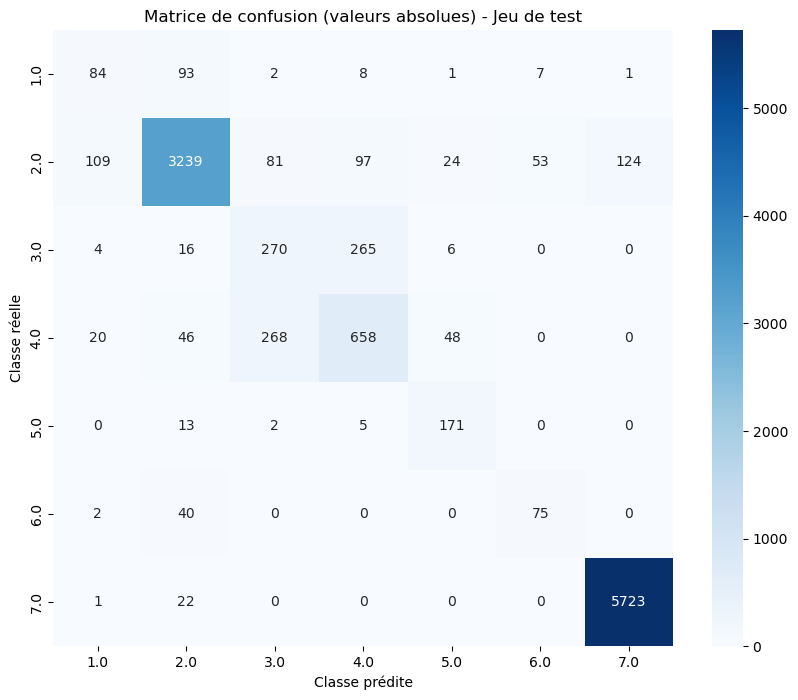

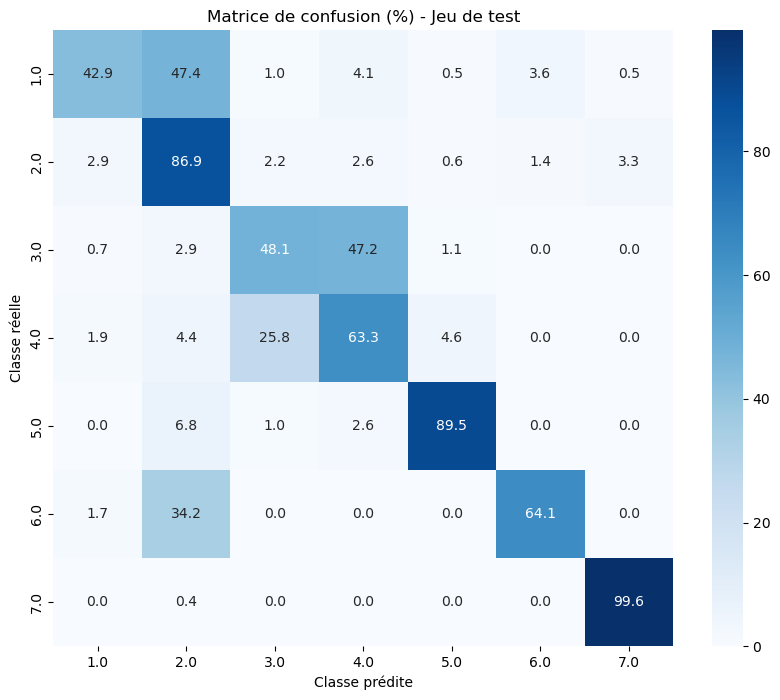

In [ ]:

# Matrice de confusion en valeurs absolues

cm = confusion_matrix(y_test, y_test_pred, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion (valeurs absolues) - Jeu de test')
plt.show()

# Matrice de confusion en pourcentages

cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # pourcentage par ligne

plt.figure(figsize=(10, 8))
sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.ylabel('Classe réelle')
plt.xlabel('Classe prédite')
plt.title('Matrice de confusion (%) - Jeu de test')
plt.show()
